# EECS 498-007/598-005 Assignment 2-2: Two Layer Neural Network

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Your NAME, #XXXXXXXX

# Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as Assignment 1. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['two_layer_net.ipynb', 'eecs598', 'two_layer_net.py', 'linear_classifier.py', 'linear_classifier.ipynb', 'challenge_problem.py']
```

In [4]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A2 folder, then '2020FA/A2'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2020FA/A2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS231n/A2'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['linear_classifier.ipynb', 'two_layer_net.py', 'challenge_problem.ipynb', 'linear_classifier.py', 'eecs598', 'two_layer_net.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from two_layer_net.py!
Hello from a2_helpers.py!
```

as well as the last edit time for the file `two_layer_net.py`.

In [5]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from two_layer_net import hello_two_layer_net
hello_two_layer_net()

from eecs598.a2_helpers import hello_helper
hello_helper()

two_layer_net_path = os.path.join(GOOGLE_DRIVE_PATH, 'two_layer_net.py')
two_layer_net_edit_time = time.ctime(os.path.getmtime(two_layer_net_path))
print('two_layer_net.py last edited on %s' % two_layer_net_edit_time)

Hello from two_layer_net.py!
Hello from a2_helpers.py!
two_layer_net.py last edited on Sun Jan 23 22:17:00 2022


## Miscellaneous

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [6]:
import eecs598
import torch
import matplotlib.pyplot as plt
import statistics
import random
import time
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [7]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

We train the network with a softmax loss function and L2 regularization on the weight matrices. The network uses a ReLU nonlinearity after the first fully connected layer. 

In other words, the network has the following architecture:

  input - fully connected layer - ReLU - fully connected layer - softmax

The outputs of the second fully-connected layer are the scores for each class.

**Note**: When you implment the regularization over W, **please DO NOT multiply the regularization term by 1/2** (no coefficient). 






## Play with a toy data

The inputs to our network will be a batch of $N$ (`num_inputs`) $D$-dimensional vectors (`input_size`); the hidden layer will have $H$ hidden units (`hidden_size`), and we will predict classification scores for $C$ categories (`num_classes`). This means that the learnable weights and biases of the network will have the following shapes:

*   W1: First layer weights; has shape (D, H)
*   b1: First layer biases; has shape (H,)
*   W2: Second layer weights; has shape (H, C)
*   b2: Second layer biases; has shape (C,)

We will use `a2_helpers.get_toy_data` function to generate random weights for a small toy model while we implement the model.

### Forward pass: compute scores
Like in the Linear Classifiers exercise, we want to write a function that takes as input the model weights and a batch of images and labels, and returns the loss and the gradient of the loss with respect to each model parameter.

However rather than attempting to implement the entire function at once, we will take a staged approach and ask you to implement the full forward and backward pass one step at a time.

First we will implement the forward pass of the network which uses the weights and biases to compute scores for all inputs in `nn_forward_pass`.

Compute the scores and compare with the answer. The distance gap should be smaller than 1e-10.

In [10]:
import eecs598
from eecs598.a2_helpers import get_toy_data
from two_layer_net import nn_forward_pass

eecs598.reset_seed(0)
toy_X, toy_y, params = get_toy_data()

# YOUR_TURN: Implement the score computation part of nn_forward_pass
scores, _ = nn_forward_pass(params, toy_X)
print('Your scores:')
print(scores)
print(scores.dtype)
print()
print('correct scores:')
correct_scores = torch.tensor([
        [ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], dtype=torch.float32, device=scores.device)
print(correct_scores)
print()

# The difference should be very small. We get < 1e-10
scores_diff = (scores - correct_scores).abs().sum().item()
print('Difference between your scores and correct scores: %.2e' % scores_diff)

Your scores:
tensor([[ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], device='cuda:0')
torch.float32

correct scores:
tensor([[ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], device='cuda:0')

Difference between your scores and correct scores: 2.24e-11


### Forward pass: compute loss
Now, we implement the first part of `nn_forward_backward` that computes the data and regularization loss.

For the data loss, we will use the softmax loss. For the regularization loss we will use L2 regularization on the weight matrices `W1` and `W2`; we will not apply regularization loss to the bias vectors `b1` and `b2`.

First, Let's run the following to check your implementation.

We compute the loss for the toy data, and compare with the answer computed by our implementation. The difference between the correct and computed loss should be less than `1e-4`.

In [20]:
import eecs598
from eecs598.a2_helpers import get_toy_data
from two_layer_net import nn_forward_backward

eecs598.reset_seed(0)
toy_X, toy_y, params = get_toy_data()

# YOUR_TURN: Implement the loss computation part of nn_forward_backward
loss, _ = nn_forward_backward(params, toy_X, toy_y, reg=0.05)
print('Your loss: ', loss.item())
correct_loss = 1.0986121892929077
print('Correct loss: ', correct_loss)
diff = (correct_loss - loss).item()

# should be very small, we get < 1e-4
print('Difference: %.4e' % diff)

Your loss:  1.0986121892929077
Correct loss:  1.0986121892929077
Difference: 0.0000e+00


### Backward pass
Now implement the backward pass for the entire network in `nn_forward_backward`.

After doing so, we will use numeric gradient checking to see whether the analytic gradient computed by our backward pass mateches a numeric gradient.

We will use the functions `eecs598.grad.compute_numeric_gradient` and `eecs598.grad.rel_error` to help with numeric gradient checking. We can learn more about these functions using the `help` command:


In [13]:
help(eecs598.grad.compute_numeric_gradient)
print('-' * 80)
help(eecs598.grad.rel_error)

Help on function compute_numeric_gradient in module eecs598.grad:

compute_numeric_gradient(f, x, dLdf=None, h=1e-07)
    Compute the numeric gradient of f at x using a finite differences
    approximation. We use the centered difference:
    
    df    f(x + h) - f(x - h)
    -- ~= -------------------
    dx           2 * h
    
    Function can also expand this easily to intermediate layers using the
    chain rule:
    
    dL   df   dL
    -- = -- * --
    dx   dx   df
    
    Inputs:
    - f: A function that inputs a torch tensor and returns a torch scalar
    - x: A torch tensor giving the point at which to compute the gradient
    - dLdf: optional upstream gradient for intermediate layers
    - h: epsilon used in the finite difference calculation
    Returns:
    - grad: A tensor of the same shape as x giving the gradient of f at x

--------------------------------------------------------------------------------
Help on function rel_error in module eecs598.grad:

rel_error(x, y

Now we will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check.

You should see relative errors less than `1e-4` for all parameters.

In [19]:
import eecs598
from eecs598.a2_helpers import get_toy_data
from two_layer_net import nn_forward_backward

eecs598.reset_seed(0)

reg = 0.05
toy_X, toy_y, params = get_toy_data(dtype=torch.float64)

# YOUR_TURN: Implement the gradient computation part of nn_forward_backward
#            When you implement the gradient computation part, you may need to 
#            implement the `hidden` output in nn_forward_pass, as well.
loss, grads = nn_forward_backward(params, toy_X, toy_y, reg=reg)

for param_name, grad in grads.items():
  param = params[param_name]
  f = lambda w: nn_forward_backward(params, toy_X, toy_y, reg=reg)[0]
  grad_numeric = eecs598.grad.compute_numeric_gradient(f, param)
  error = eecs598.grad.rel_error(grad, grad_numeric)
  print('%s max relative error: %e' % (param_name, error))

W2 max relative error: 1.261262e-06
b2 max relative error: 3.122771e-09
W1 max relative error: 1.441750e-06
b1 max relative error: 8.239303e-06


### Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. 

Look at the function `nn_train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. 

You will also have to implement `nn_predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains. 

Once you have implemented the method, run the code below to train a two-layer network on toy data. Your final training loss should be less than 1.0.

Final training loss:  0.5211756229400635


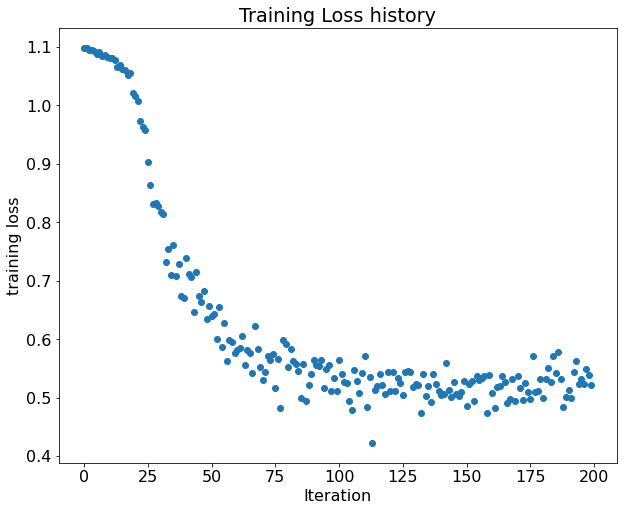

In [22]:
import eecs598
from eecs598.a2_helpers import get_toy_data
from two_layer_net import nn_forward_backward, nn_train, nn_predict

eecs598.reset_seed(0)
toy_X, toy_y, params = get_toy_data()

# YOUR_TURN: Implement the nn_train function.
#            You may need to check nn_predict function (the "pred_func") as well.
stats = nn_train(params, nn_forward_backward, nn_predict, toy_X, toy_y, toy_X, toy_y,
                 learning_rate=1e-1, reg=1e-6,
                 num_iters=200, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'], 'o')
plt.xlabel('Iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

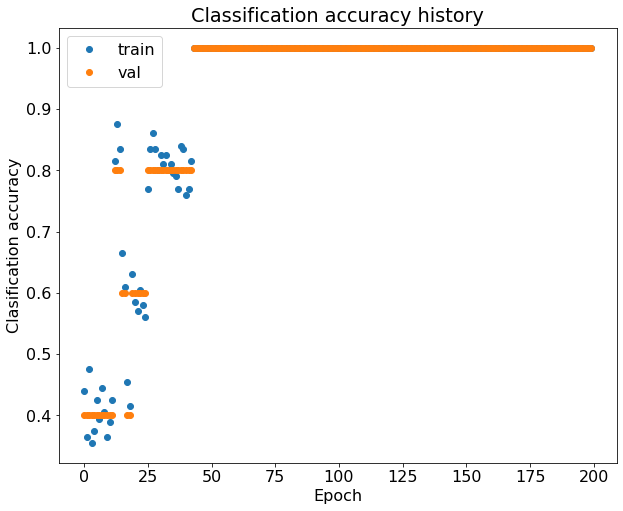

In [23]:
# Plot the loss function and train / validation accuracies
plt.plot(stats['train_acc_history'], 'o', label='train')
plt.plot(stats['val_acc_history'], 'o', label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

## Testing our NN on a real dataset: CIFAR-10
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./cifar-10-python.tar.gz


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


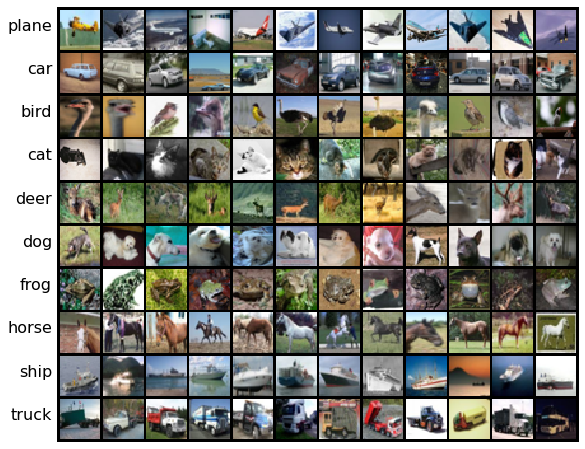

Train data shape:  torch.Size([40000, 3072])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3072])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3072])
Test labels shape:  torch.Size([10000])


In [24]:
import eecs598

# Invoke the above function to get our data.
eecs598.reset_seed(0)
data_dict = eecs598.data.preprocess_cifar10(dtype=torch.float64)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

### Wrap all function into a Class
We will use the class `TwoLayerNet` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are PyTorch tensors.




### Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [25]:
import eecs598
from two_layer_net import TwoLayerNet

input_size = 3 * 32 * 32
hidden_size = 36
num_classes = 10

# fix random seed before we generate a set of parameters
eecs598.reset_seed(0)
net = TwoLayerNet(input_size, hidden_size, num_classes, dtype=data_dict['X_train'].dtype, device=data_dict['X_train'].device)

# Train the network
stats = net.train(data_dict['X_train'], data_dict['y_train'],
                  data_dict['X_val'], data_dict['y_val'],
                  num_iters=500, batch_size=1000,
                  learning_rate=1e-2, learning_rate_decay=0.95,
                  reg=0.25, verbose=True)

# Predict on the validation set
y_val_pred = net.predict(data_dict['X_val'])
val_acc = 100.0 * (y_val_pred == data_dict['y_val']).double().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

iteration 0 / 500: loss 2.302864
iteration 100 / 500: loss 2.302695
iteration 200 / 500: loss 2.302669
iteration 300 / 500: loss 2.302552
iteration 400 / 500: loss 2.302571
Validation accuracy: 9.77%


### Debug the training
With the default parameters we provided above, you should get a validation accuracy less than 10% on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

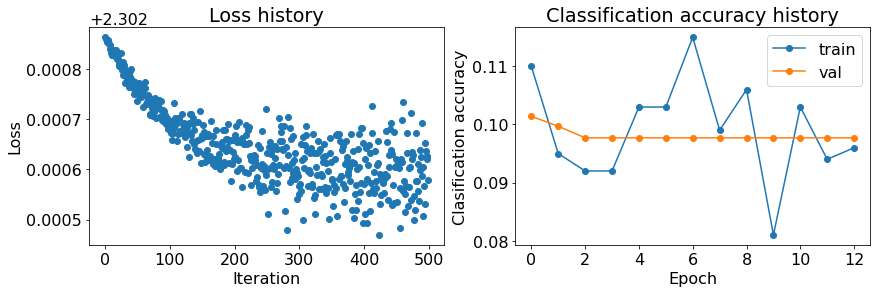

In [26]:
# Plot the loss function and train / validation accuracies
from eecs598.a2_helpers import plot_stats

plot_stats(stats)

Similar to SVM and Softmax classifier, let's visualize the weights.

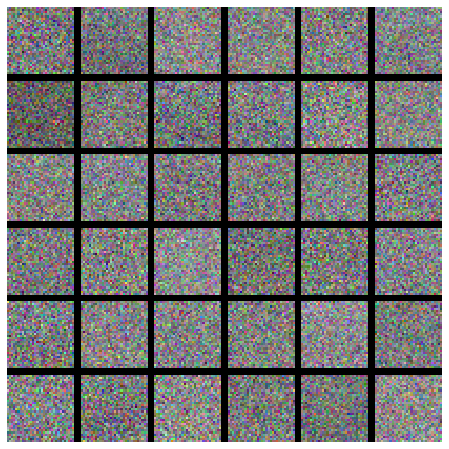

In [27]:
from eecs598.a2_helpers import show_net_weights 

show_net_weights(net)

### What's wrong?
Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

#### Capacity?
Our initial model has very similar performance on the training and validation sets. This suggests that the model is underfitting, and that its performance might improve if we were to increase its capacity.

One way we can increase the capacity of a neural network model is to increase the size of its hidden layer. Here we investigate the effect of increasing the size of the hidden layer. The performance (as measured by validation-set accuracy) should increase as the size of the hidden layer increases; however it may show diminishing returns for larger layer sizes.

train with hidden size: 2
train with hidden size: 8
train with hidden size: 32
train with hidden size: 128


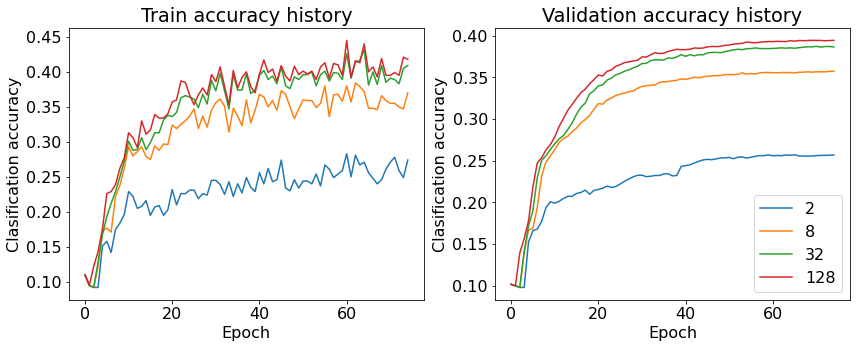

In [28]:
import eecs598
from eecs598.a2_helpers import plot_acc_curves
from two_layer_net import TwoLayerNet

hidden_sizes = [2, 8, 32, 128] 
lr = 0.1
reg = 0.001

stat_dict = {}
for hs in hidden_sizes:
  print('train with hidden size: {}'.format(hs))
  # fix random seed before we generate a set of parameters
  eecs598.reset_seed(0)
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device, dtype=data_dict['X_train'].dtype)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[hs] = stats

plot_acc_curves(stat_dict)

#### Regularization?
Another possible explanation for the small gap we saw between the train and validation accuracies of our model is regularization. In particular, if the regularization coefficient were too high then the model may be unable to fit the training data.

We can investigate the phenomenon empirically by training a set of models with varying regularization strengths while fixing other hyperparameters.

You should see that setting the regularization strength too high will harm the validation-set performance of the model:

train with regularization: 0
train with regularization: 1e-05
train with regularization: 0.001
train with regularization: 0.1


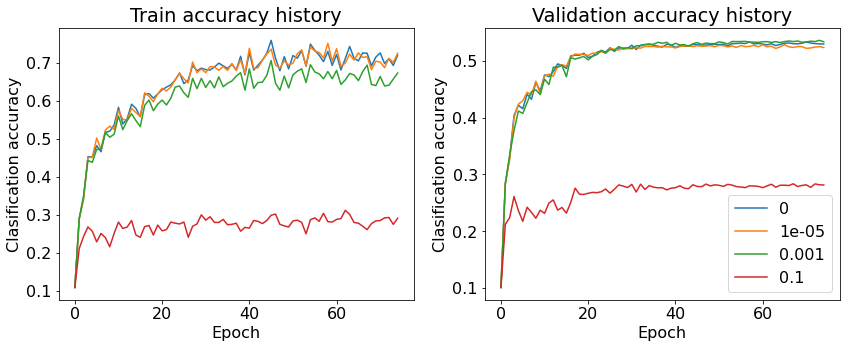

In [29]:
import eecs598
from eecs598.a2_helpers import plot_acc_curves
from two_layer_net import TwoLayerNet

hs = 128
lr = 1.0
regs = [0, 1e-5, 1e-3, 1e-1]

stat_dict = {}
for reg in regs:
  print('train with regularization: {}'.format(reg))
  # fix random seed before we generate a set of parameters
  eecs598.reset_seed(0)
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device, dtype=data_dict['X_train'].dtype)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[reg] = stats

plot_acc_curves(stat_dict)

#### Learning Rate?
Last but not least, we also want to see the effect of learning rate with respect to the performance.

train with learning rate: 0.0001
train with learning rate: 0.01
train with learning rate: 1.0
train with learning rate: 100.0


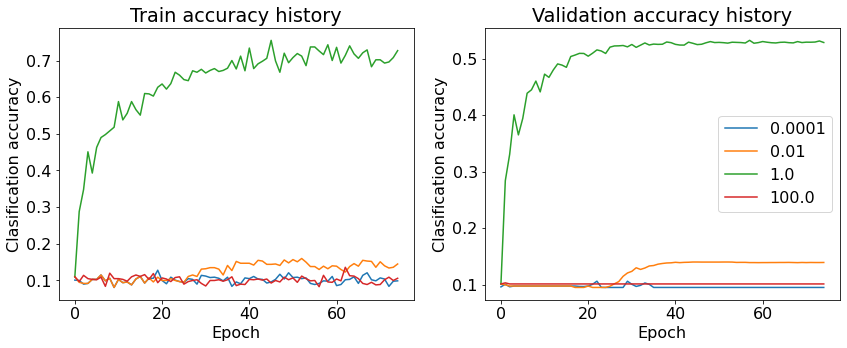

In [30]:
import eecs598
from eecs598.a2_helpers import plot_acc_curves
from two_layer_net import TwoLayerNet

hs = 128
lrs = [1e-4, 1e-2, 1e0, 1e2]
reg = 1e-4

stat_dict = {}
for lr in lrs:
  print('train with learning rate: {}'.format(lr))
  # fix random seed before we generate a set of parameters
  eecs598.reset_seed(0)
  net = TwoLayerNet(3 * 32 * 32, hs, 10, device=data_dict['X_train'].device, dtype=data_dict['X_train'].dtype)
  stats = net.train(data_dict['X_train'], data_dict['y_train'], data_dict['X_val'], data_dict['y_val'],
            num_iters=3000, batch_size=1000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=False)
  stat_dict[lr] = stats

plot_acc_curves(stat_dict)

### Tune your hyperparameters

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, number of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Plots**. To guide your hyperparameter search, you might consider making auxiliary plots of training and validation performance as above, or plotting the results arising from different hyperparameter combinations as we did in the Linear Classifier notebook. You should feel free to plot any auxiliary results you need in order to find a good network, but we don't require any particular plots from you.

**Approximate results**. To get full credit for the assignment, you should achieve a classification accuracy above 50% on the validation set.

(Our best model gets a validation-set accuracy 56.44% -- did you beat us?)

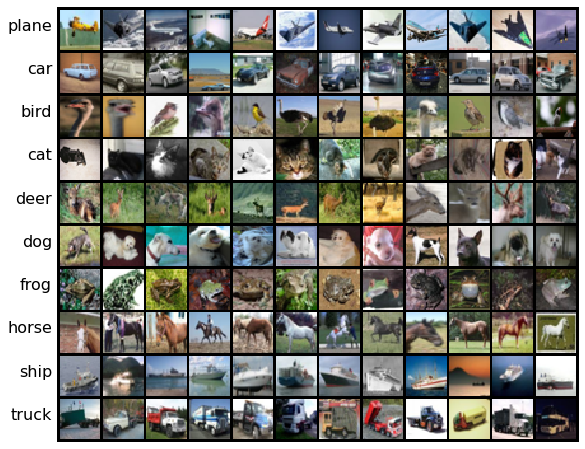

train with hyperparameters: leaning_rate is:1.0, hidden_size is:128,.             regularization_strength is:1e-05, learning_rate_decacy is:1.0
train with hyperparameters: leaning_rate is:1.0, hidden_size is:128,.             regularization_strength is:1e-05, learning_rate_decacy is:0.97
train with hyperparameters: leaning_rate is:1.0, hidden_size is:128,.             regularization_strength is:1e-05, learning_rate_decacy is:0.95
train with hyperparameters: leaning_rate is:1.0, hidden_size is:128,.             regularization_strength is:1e-05, learning_rate_decacy is:0.93
train with hyperparameters: leaning_rate is:1.0, hidden_size is:256,.             regularization_strength is:1e-05, learning_rate_decacy is:1.0
train with hyperparameters: leaning_rate is:1.0, hidden_size is:256,.             regularization_strength is:1e-05, learning_rate_decacy is:0.97
train with hyperparameters: leaning_rate is:1.0, hidden_size is:256,.             regularization_strength is:1e-05, learning_rate_de

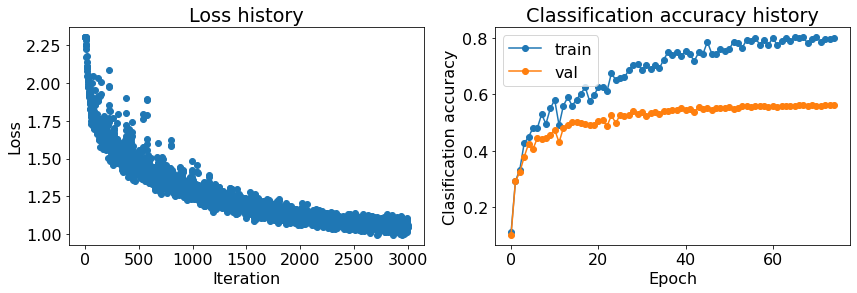

Saved in drive/My Drive/CS231n/A2/nn_best_model.pt


In [31]:
import os
import eecs598
from two_layer_net import TwoLayerNet, find_best_net, nn_get_search_params

# running this model on float64 may needs more time, so set it as float32
eecs598.reset_seed(0)
data_dict = eecs598.data.preprocess_cifar10(dtype=torch.float32)

# store the best model into this 
eecs598.reset_seed(0)
best_net, best_stat, best_val_acc = find_best_net(data_dict, nn_get_search_params)
print(best_val_acc)

plot_stats(best_stat)

# save the best model
path = os.path.join(GOOGLE_DRIVE_PATH, 'nn_best_model.pt')
best_net.save(path)

In [32]:
# Check the validation-set accuracy of your best model
y_val_preds = best_net.predict(data_dict['X_val'])
val_acc = 100 * (y_val_preds == data_dict['y_val']).double().mean().item()
print('Best val-set accuracy: %.2f%%' % val_acc)

Best val-set accuracy: 56.02%


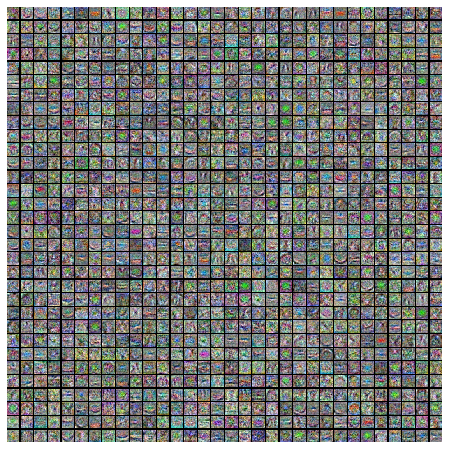

In [33]:
from eecs598.a2_helpers import show_net_weights
# visualize the weights of the best network
show_net_weights(best_net)

### Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set. To get full credit for the assignment, you should achieve over 50% classification accuracy on the test set.

(Our best model gets 56.03% test-set accuracy -- did you beat us?)

In [34]:
y_test_preds = best_net.predict(data_dict['X_test'])
test_acc = 100 * (y_test_preds == data_dict['y_test']).double().mean().item()
print('Test accuracy: %.2f%%' % test_acc)

Test accuracy: 55.90%
